In [113]:
import pandas as pd
import warnings
import statistics 

from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import RepeatedStratifiedKFold
import xam
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 3000)
pd.set_option("display.max_rows",3000)
register_matplotlib_converters()
sns.set()

In [114]:
#label encoding, I use manual labeling to transform category to numeric
dict_x21 = {'Jan':1,'Feb':2,'Mar':3, 'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
dict_x79 = {'Laki-laki':1,'Perempuan':2}
dict_x108 = {'Tidak sekolah':1,'SD':2,'SMP':3,'SMA/SMK':4,'S1/S2/S3':5}
dict_x112 = {'Jan':1,'Feb':2,'Mar':3, 'Apr':4,'May':5,'Jun':6,'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
dict_x89= {'DKI Jakarta':1,'Kalimantan Timur':2,'Banten':3,'Kalimantan Utara':4,'Sulawesi Utara':5,'Bali':6,
          'Kalimantan Tengah':7,'Jawa Barat':8,'Bangka Belitung':9,'Jambi':10,'Kalimantan Selatan':11,
          'Jawa Timur':12,'Maluku Utara':13,'Sumatera Utara':14,'Sumatera Barat':15,'Sumatera Selatan':16,
          'Sulawesi Tenggara':17,'Sulawesi Tengah':18,'Maluku':19,'Bengkulu':20,'Gorontalo':21,'NTB':22,
          'Kalimantan Barat':23,'DI Yogyakarta':24,'Jawa Tengah':25,'Sulawesi Barat':26,'NTT':27}

In [115]:
#specify category columns (this is based on data type either int, category, string, stc)
col_cat = ['x6','x7','x22','x51','x63','x80','x93','x96','x104','x117','x118','x21','x79','x108','x112','x89'] 

In [116]:
df_train = pd.read_csv('FDC/findata_challenge_train.csv') #read train data
df_train.dropna(axis=0,inplace=True) # drop row witg missing values
df_test = pd.read_csv('FDC/findata_challenge_test.csv') #read test data
df_test['y'] = 0 #assign dummy label 

#assign data identifier either training or testing
df_train['data'] = 'training'
df_test['data'] = 'testing'
df_concat = pd.concat([df_train,df_test]) # combine training and testing

#transform string / category data to numeric
df_concat['x21'] = df_concat['x21'].map(dict_x21)
df_concat['x79'] = df_concat['x79'].map(dict_x79)
df_concat['x108'] = df_concat['x108'].map(dict_x108)
df_concat['x112'] = df_concat['x112'].map(dict_x112)
df_concat['x89'] = df_concat['x89'].map(dict_x89)

#fill missing values for testing data
df_concat[col_cat] = df_concat[col_cat].fillna(df_concat[col_cat].mode().squeeze()) #fill in category columns with modus
df_concat = df_concat.fillna(df_concat.mean()) #fill in numeric columns with mean
df_concat[col_cat] = df_concat[col_cat].astype('str') #assign all category columns to string type, this is required for feature combiner

#get category columns that will be combined
a = df_concat.select_dtypes(include=['int','object', 'category']).columns.tolist()
a.remove('data') # data columns is only identifier, it is not required as a feature

In [117]:
#choose data training
df_training = df_concat[df_concat['data']=='training']

In [118]:
#encoding category columns by using bayesian target encoder 
encoder = xam.feature_extraction.BayesianTargetEncoder(
    columns=a,
    prior_weight=100,
    suffix='')
df_training_ = encoder.fit_transform(df_training.drop(['data','y'],axis=1), df_training['y'])

[12:27:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:27:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


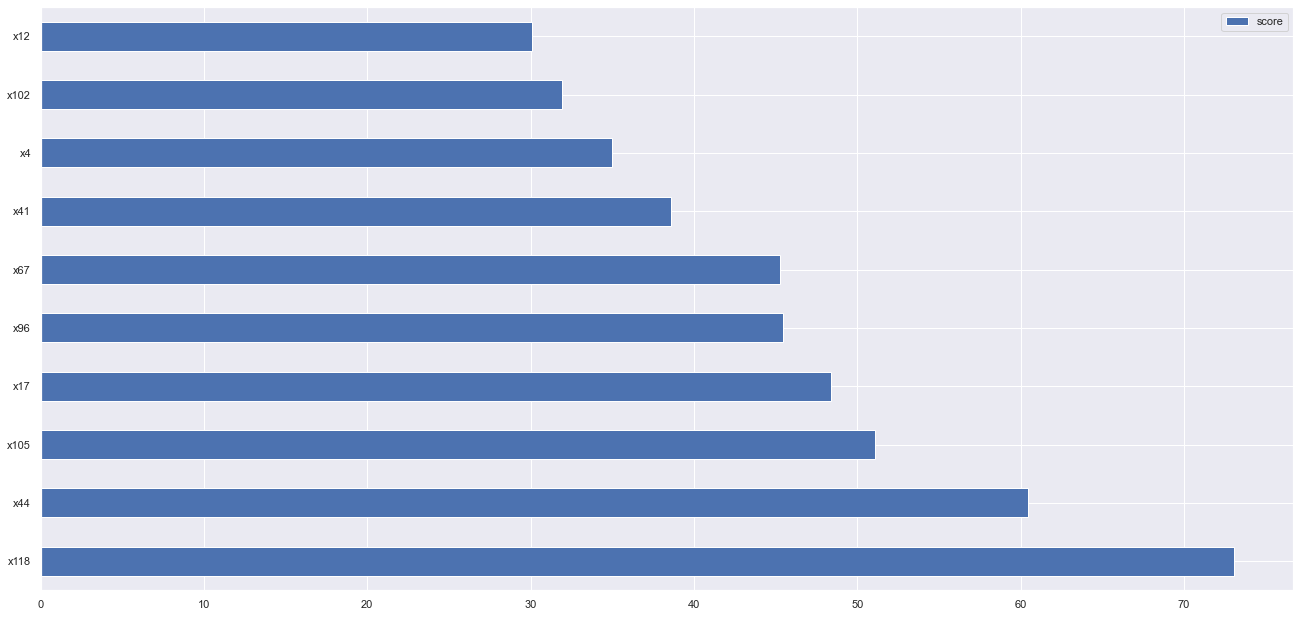

In [119]:
#this part is to check feature importance using original features and default xgboost hyperparams
import matplotlib.pyplot as plt
from xgboost import plot_importance

clf = xgb.XGBClassifier(seed=10,objective='binary:logistic', verbose=-1)
clf.fit(df_training_,df_training['y'])
feature_important = clf.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 10 features

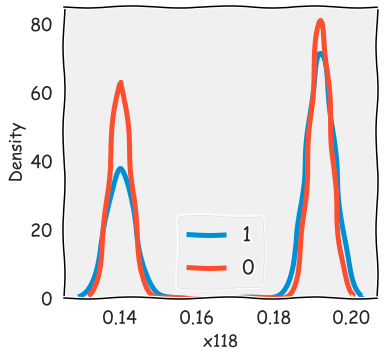

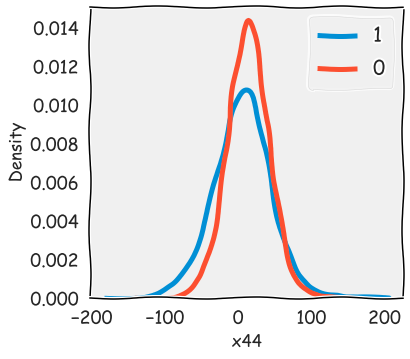

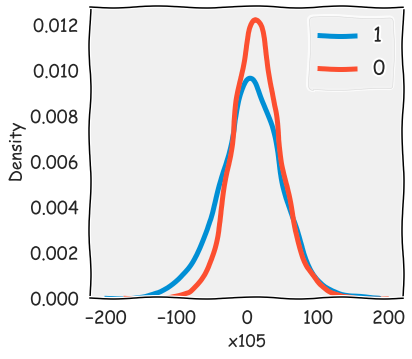

In [120]:
#plot histogram between two classes for top three important parameters
for col in data.index[:3]:
    plt.style.use('fivethirtyeight') 
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.kdeplot(df_training_[df_training['y']==1][col], ax=ax, label='1', lw=5, alpha=0.6);
        sns.kdeplot(df_training_[df_training['y']==0][col], ax=ax, label='0', lw=5, alpha=0.6);
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.legend(fontsize=20);
        
# analysis result --> Top three parameters don't show separation between two classes --> need to create new feature

In [121]:
#this is to get new combined features + original features
new_feat = xam.feature_extraction.FeatureCombiner(separator='+', orders=[2,3]).fit_transform(df_concat[a]) 
df_concat = pd.concat([df_concat.drop(a,axis=1), new_feat], axis=1, join="inner") #create dataframe with new features

In [122]:
#seperate dataframe to training and testing
df_training = df_concat[df_concat['data']=='training']
df_testing = df_concat[df_concat['data']=='testing']

In [123]:
#convert category data to string data type
df_training[new_feat.columns.tolist()] = df_training[new_feat.columns.tolist()].astype('str')
df_testing[new_feat.columns.tolist()] = df_testing[new_feat.columns.tolist()].astype('str')

In [124]:
#encoding category columns by using bayesian target encoder 
encoder = xam.feature_extraction.BayesianTargetEncoder(
    columns=new_feat.columns.tolist(),
    prior_weight=100,
    suffix='')
df_training_ = encoder.fit_transform(df_training.drop(['data','y'],axis=1), df_training['y'])
df_testing_ = encoder.transform(df_testing.drop(['data','y'],axis=1))

[12:44:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


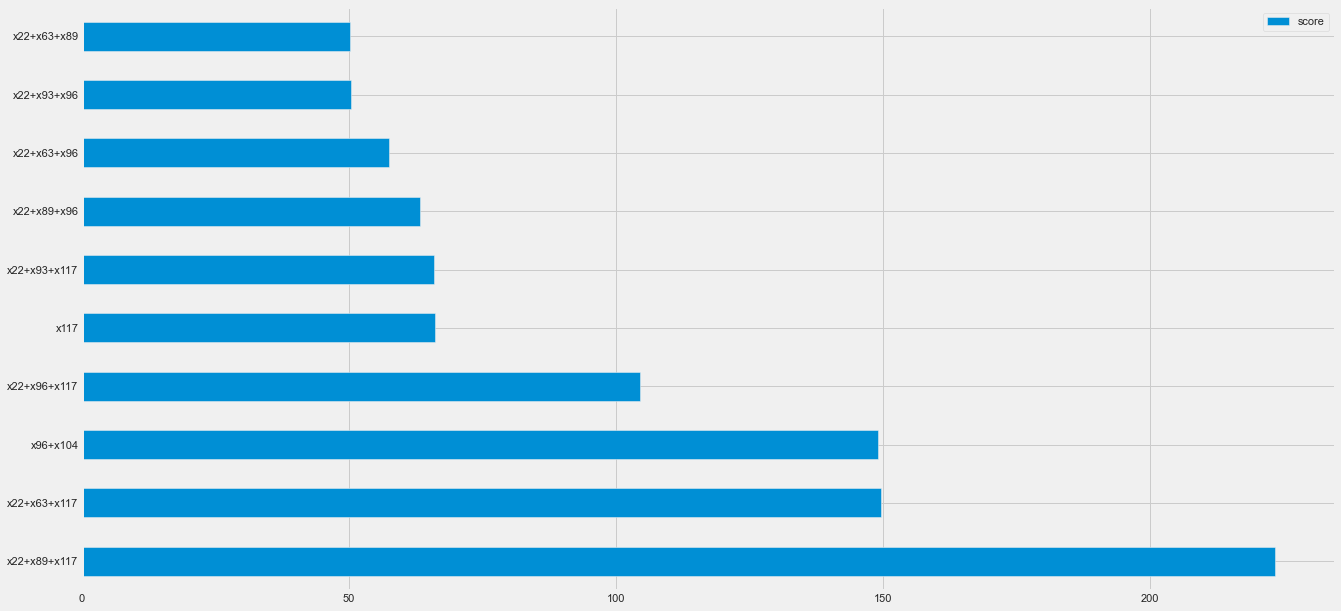

In [125]:
#this part is to check feature importance using original features and default xgboost hyperparams
import matplotlib.pyplot as plt
from xgboost import plot_importance

clf = xgb.XGBClassifier(seed=10,objective='binary:logistic', verbose=-1)
clf.fit(df_training_,df_training['y'])
feature_important = clf.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 10 features

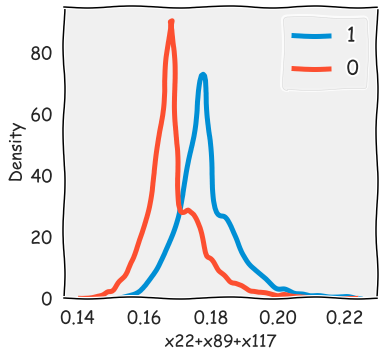

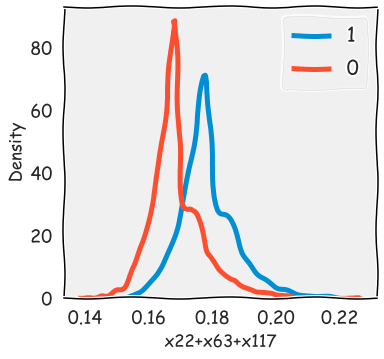

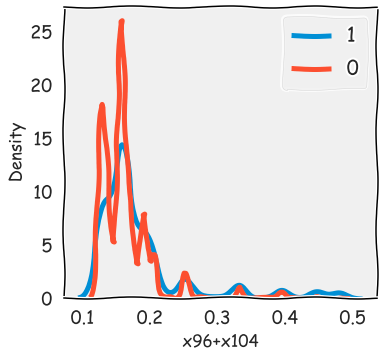

In [126]:
#plot histogram between two classes for top three important parameters
for col in data.index[:3]:
    plt.style.use('fivethirtyeight') 
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.kdeplot(df_training_[df_training['y']==1][col], ax=ax, label='1', lw=5, alpha=0.6);
        sns.kdeplot(df_training_[df_training['y']==0][col], ax=ax, label='0', lw=5, alpha=0.6);
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.legend(fontsize=20);
        
# analysis result --> Top three parameters show separation between two classes compared to original features

In [127]:
#hyperparameters for each base models
catboost_params = {'bagging_temperature': 15.985602506197749, 
                   'border_count': 25, 
                   'l2_leaf_reg': 110.96118796511317,
                   'learning_rate': 0.5760596526529586, 
                   'max_depth': 5, 
                   'n_estimators': 96, 
                   'random_strength': 24.96821924094007}

xgboost_params = {'colsample_bylevel': 0.5180759078449573, 
                  'colsample_bynode': 0.772575558243465, 
                  'colsample_bytree': 0.7466595726562169, 
                  'gamma': 1.052138611786054, 
                  'learning_rate': 0.8463113549682633, 
                  'max_depth': 3,
                  'min_child_weight': 23,
                  'n_estimators': 40, 
                  'reg_alpha': 2, 
                  'reg_lambda': 3.2500749184919817, 
                  'seed': 13}

lgbm_params = {'boosting_type': 'gbdt', 
               'class_weight': None, 
               'colsample_bytree': 1.0, 
               'importance_type': 'split',
               'min_child_samples': 24, 
               'min_split_gain': 0.0,
               'objective': None, 
               'random_state': 0, 
               'reg_alpha': 0.0, 
               'reg_lambda': 0.0, 
               'silent': True,
               'subsample': 1.0, 
               'subsample_for_bin': 200000, 
               'subsample_freq': 0, 
               'num_leaves': 15,
               'min_child_weight': 0,
               'max_depth': 11, 
               'learning_rate': 0.3330187253790324, 
               'min_data_in_bin': 1,
               'min_data': 1, 
               'bagging_fraction': 0.7383799778083913,
               'lambda_l1': 0.3044318357497682, 
               'lambda_l2': 0.5410002260765876, 
               'scale_pos_weight': 19.457166357872516, 
               'n_estimators': 181}

rf_params = {'max_depth': 13,
             'max_leaf_nodes': 10, 
             'min_impurity_decrease': 0.0002441992684286687, 
             'min_samples_leaf': 0.0291684331158525, 
             'min_samples_split': 0.04948164092559865,
             'n_estimators': 94}

dt_params = {'max_depth': 11.0, 'min_samples_split': 0.022570300157820265}

In [128]:
#specify custom metric roc_auc
def get_profit(y_true, y_pred):
    score= roc_auc_score(y_true, y_pred)
    return score


class roc_auc_metric_catboost:
    def is_max_optimal(self):
        return True # greater is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        y_pred = approx
        y_true = np.array(target).astype(int)

        output_weight = 1 # weight is not used

        score = get_profit(y_true, y_pred)
 
        return score, output_weight

    def get_final_error(self, error, weight):
        return error
    
def roc_auc_lgbm(dtrain,y_pred):
    labels = dtrain
    return 'roc_auc', roc_auc_score(labels, y_pred), True

def roc_auc_xgb(y_pred, dtrain):
    labels = dtrain.get_label()
    y_pred = 1.0 / (1.0 + np.exp(-y_pred)) 
    return '-roc_auc', -roc_auc_score(labels, y_pred)

In [129]:
#evaluate performance of base models
base_models = {
     'Catboost': CatBoostClassifier(**catboost_params,eval_metric=roc_auc_metric_catboost()),
     'XGB': xgb.XGBClassifier(**xgboost_params, objective='binary:logistic',disable_default_eval_metric= True),
     'LightGBM': lgb.LGBMClassifier(**lgbm_params, metric="custom"),
     #'RF' : RandomForestClassifier(**rf_params),
     #'DT' : DecisionTreeClassifier(**dt_params)
}

label_kfold = RepeatedStratifiedKFold(n_splits=7, n_repeats=3,random_state=12)
X, y = df_training_, df_training[['y']]
X_test, y_test = df_testing_, df_testing[['y']]

for name, clf in dict(base_models).items():
    score_list = []
    score_list_train = []
    predict_train_base = []
    predict_test_base = []
    for train_index, val_index in label_kfold.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        if name=='Catboost':
            clf.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], use_best_model=True, early_stopping_rounds=10,verbose=False)  
            score_train = clf.best_score_['validation_0']['roc_auc_metric_catboost']
            score_val = clf.best_score_['validation_1']['roc_auc_metric_catboost']  
        elif name=='XGB':
            clf.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric=roc_auc_xgb,early_stopping_rounds=10,verbose=False)
            score_train = abs(clf.evals_result_['validation_0']['-roc_auc'][clf.best_iteration])
            score_val = abs(clf.best_score)
        elif name=='LightGBM':
            clf.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)],
                           #categorical_feature=col_cat,
                           eval_metric=roc_auc_lgbm,early_stopping_rounds=10,verbose=False)
            score_train = clf.best_score_['training']['roc_auc']
            score_val = clf.best_score_['valid_1']['roc_auc']
        else:
            clf.fit(X_train,y_train)
            score_train = roc_auc_score(y_train, clf.predict(X_train))
            score_val = roc_auc_score(y_val, clf.predict(X_val))     
        score_list_train.append(score_train)
        score_list.append(score_val)
    score_avg = statistics.mean(score_list)
    score_avg_train = statistics.mean(score_list_train)
    print('roc_auc for validation '+name+' :',round(score_avg,4),'roc_auc for training '+name+' :',round(score_avg_train,4))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

roc_auc for validation Catboost : 0.9917 roc_auc for training Catboost : 0.9961
roc_auc for validation XGB : 0.9851 roc_auc for training XGB : 0.9909
roc_auc for validation LightGBM : 0.9927 roc_auc for training LightGBM : 0.9998


In [130]:
#evaluate performance of stacking strategy with AUCregressor as the meta model

base_models = {
     'Catboost': CatBoostClassifier(**catboost_params,eval_metric=roc_auc_metric_catboost()),
     'XGB': xgb.XGBClassifier(**xgboost_params, objective='binary:logistic',disable_default_eval_metric= True),
     'LightGBM': lgb.LGBMClassifier(**lgbm_params, metric="custom"),
     #'RF' : RandomForestClassifier(**rf_params),
     #'DT' : DecisionTreeClassifier(**dt_params)
}

label_kfold = RepeatedStratifiedKFold(n_splits=7, n_repeats=3,random_state=12)
X, y = df_training_, df_training[['y']]
X_test, y_test = df_testing_, df_testing[['y']]

score_list = []
score_list_train = []
for train_index, val_index in label_kfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    predict_train_list = []
    predict_test_list = []
    actual_train_list = []
    actual_test_list = []
    for name, clf in dict(base_models).items():
        if name=='Catboost':
            clf.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], use_best_model=True, early_stopping_rounds=10,verbose=False)  
            predict_train = clf.predict_proba(X_train)[:,1]
            predict_test = clf.predict_proba(X_val)[:,1]
        elif name=='XGB':
            clf.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric=roc_auc_xgb,early_stopping_rounds=10,verbose=False)
            predict_train = clf.predict_proba(X_train)[:,1]
            predict_test = clf.predict_proba(X_val)[:,1]
        elif name=='LightGBM':
            clf.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric=roc_auc_lgbm,early_stopping_rounds=10,verbose=False)
            predict_train = clf.predict_proba(X_train)[:,1]
            predict_test = clf.predict_proba(X_val)[:,1]
        else:
            clf.fit(X_train,y_train)
            predict_train = clf.predict_proba(X_train)[:,1]
            predict_test = clf.predict_proba(X_val)[:,1]
        predict_train_list.append(predict_train)
        predict_test_list.append(predict_test)
    meta_model = xam.linear_model.AUCRegressor()
    meta_model.fit(np.asarray(predict_train_list).T,y_train)
    output_train = meta_model.predict(np.asarray(predict_train_list).T)
    output_test = meta_model.predict(np.asarray(predict_test_list).T)
    score_list_train.append(roc_auc_score(y_train, output_train))  
    score_list.append(roc_auc_score(y_val, output_test))  
score_avg = statistics.mean(score_list)
score_avg_train = statistics.mean(score_list_train)
print('roc_auc for validation :',round(score_avg,4),'roc_auc for training :',round(score_avg_train,4))

roc_auc for validation : 0.9923 roc_auc for training : 0.9999


In [131]:
#Run for all training dataset and get prediction from stacking model
base_models = {
     'Catboost': CatBoostClassifier(**catboost_params,eval_metric=roc_auc_metric_catboost()),
     'XGB': xgb.XGBClassifier(**xgboost_params, objective='binary:logistic',disable_default_eval_metric= True),
     'LightGBM': lgb.LGBMClassifier(**lgbm_params, metric="custom"),
     #'RF' : RandomForestClassifier(**rf_params),
     #'DT' : DecisionTreeClassifier(**dt_params)
}

X, y = df_training_, df_training[['y']]
X_test = df_testing_

predict_train_list = []
predict_test_list = []
for name, clf in dict(base_models).items():
    if (name=='Catboost') or (name=='XGB') or (name=='LightGBM'):
        clf.fit(X, y,verbose=False)  
        predict_train = clf.predict_proba(X)[:,1]
        predict_test = clf.predict_proba(X_test)[:,1]
    else:
        clf.fit(X, y)  
        predict_train = clf.predict_proba(X)[:,1]
        predict_test = clf.predict_proba(X_test)[:,1]
    predict_train_list.append(predict_train)
    predict_test_list.append(predict_test)
    
meta_model = xam.linear_model.AUCRegressor()
meta_model.fit(np.asarray(predict_train_list).T,y)
output_train = meta_model.predict(np.asarray(predict_train_list).T)
output_test = meta_model.predict(np.asarray(predict_test_list).T)
print('roc_auc for training :',round(roc_auc_score(y, output_train),4))

roc_auc for training : 0.9998


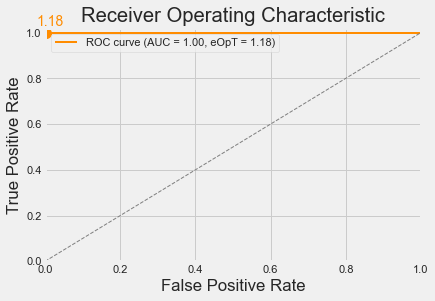

In [132]:
#evaluate ROC AUC and get optimum threshold
from dython.model_utils import roc_graph
dict_result = roc_graph(y.values.ravel(), output_train.ravel(),macro=False, micro=False)

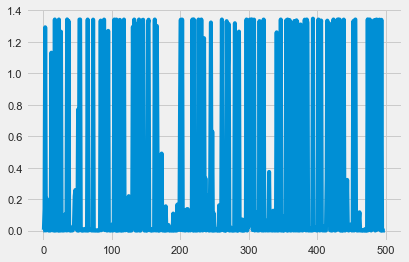

In [133]:
#inspect the result
plt.plot(output_train[:500])
plt.show()

In [134]:
#save the result
pd.DataFrame.from_dict({'Id':np.arange(0,len(output_test)),'Predicted':np.where(output_test>dict_result['0']['eopt'],1,0)}).to_csv('ramdhan_ari_wibawa-submission.csv',index=False)